In [1]:
%matplotlib inline
import matplotlib.pylab as plt, seaborn as sns, numpy as np, sys
from numpy.testing import assert_almost_equal
temp_font_size = 20
temp_tick_size = 35
sns.set_style(style='white')
from temp_tf_load import *

Using TensorFlow backend.


## potential

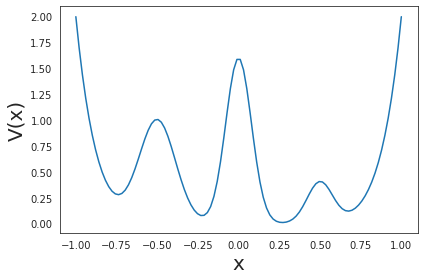

In [2]:
# define potential
def autocorr(x, t):
    return np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))[0, 1]

def potential(x):
    return 2 * (x ** 8 + 0.8 * np.exp(-80 * x ** 2) + 0.2 * np.exp(-80*(x-0.5)**2) + 0.5 * np.exp(-40 * (x+0.5)**2))
x_list = np.linspace(-1, 1, 100)
V_list = potential(x_list)
fig, ax = plt.subplots()
ax.plot(x_list, V_list)
ax.set_xlabel('x', fontsize = temp_font_size)
ax.set_ylabel('V(x)', fontsize = temp_font_size)
fig.tight_layout()

In [3]:
def get_transition_matrix(V_list, kT=1.0):
    num_points = len(V_list)
    transition = np.zeros((num_points, num_points))
    for item in range(num_points):
        p_left = np.exp(-(V_list[item - 1] - V_list[item]) / kT) if item != 0 else 0
        p_right = np.exp(-(V_list[item + 1] - V_list[item]) / kT) if item != num_points -1 else 0
        p_sum = p_left + 1 + p_right
        transition[item - 1][item] = p_left / p_sum
        transition[item][item] = 1 / p_sum
        transition[(item + 1) % num_points][item] = p_right / p_sum
    assert_almost_equal(transition.sum(axis=0), np.ones(num_points))
    return transition

In [4]:
# get transition matrices for lag time = 1 and 100
transition_1 = get_transition_matrix(V_list, kT=1)   # transition matrix with lag = 1
lag_time = 100
transition = np.linalg.matrix_power(transition_1, lag_time)  # transition matrix with lag = 100

In [5]:
def get_sorted_eigen_values_vecs(matrix):
    eigenValues, eigenVectors = np.linalg.eig(matrix)
    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors.T[idx]
    return eigenValues, eigenVectors

def inner_prod(xx, yy, equi_dist):
    return np.sum(xx * yy * equi_dist)

def normalize_state(state, equi_dist):
    return state / np.sqrt(inner_prod(state, state, equi_dist))

In [6]:
# get eigenvalues, eigenvectors of the transition matrix
eigenValues, eigenVectors = get_sorted_eigen_values_vecs(transition)
equi_dist = np.real_if_close(eigenVectors[0] / np.sum(eigenVectors[0]))

/home/mikejones/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


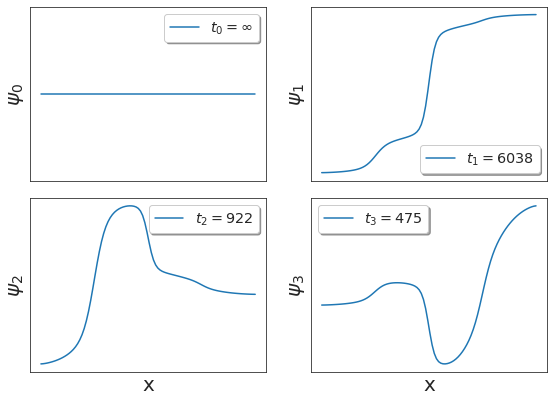

In [7]:
# get first four eigenstates of transfer matrix, which are first four slowest modes
eigenstates = [item / equi_dist for item in eigenVectors]
eigenstates = [np.real_if_close(normalize_state(item, equi_dist)) for item in eigenstates]   # normalization
th_timescales = [-lag_time / np.log(eigenValues[item]) for item in range(1, 4)]
fig, axes = plt.subplots(2,2)
for item in range(4):
    ax = axes[item // 2][item % 2]
    if item == 0: timescale_label = "$t_%d = \infty$" % item
    else: 
        timescale_label = '$t_%d = %d$' % (item, th_timescales[item - 1])
    ax.plot(x_list, eigenstates[item], label=timescale_label)
    if item > 1: ax.set_xlabel('x', fontsize=temp_font_size)
    ax.set_ylabel('$\psi_%d$' % item, fontsize=temp_font_size)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
fig.tight_layout()
plt.subplots_adjust(hspace = 0.1)
fig.set_size_inches(8, 6)

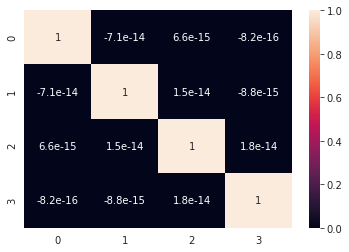

In [8]:
# check these states are orthogonal
corr_matrix = [[inner_prod(eigenstates[xx], eigenstates[yy], equi_dist) for xx in range(4)] for yy in range(4)]
sns.heatmap(corr_matrix, annot=True)

In [9]:
def run_markov_simulation(transition, x_list, start_point = None, steps = 1e6):
    num_states = len(transition)
    if start_point is None: 
        point = np.random.randint(num_states)
    else: point = start_point
    traj = [point]
    for _ in range(int(steps - 1)):
        rand_num = np.random.rand()
        if rand_num < transition[point - 1][point]:
            point -= 1
        elif rand_num > transition[point][point] + transition[point - 1][point]:
            point = (point + 1) % num_states
        traj.append(point)
    traj = np.array(traj)
    return traj, x_list[traj]

def traj_to_bin(traj, x_list):
    return np.where(x_list == traj)[1]

In [10]:
# generate simulation data
traj_bins, traj = run_markov_simulation(transition_1, x_list, steps=5e6)
traj = traj.reshape(-1, 1)

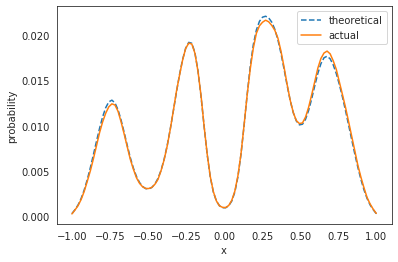

In [11]:
# compare theoretical and actual probability distributions
equi_dist_actual = []
for xx in np.unique(traj):
    equi_dist_actual.append(np.sum(traj == xx))
equi_dist_actual = np.array(equi_dist_actual).astype(float)
equi_dist_actual /= np.sum(equi_dist_actual)
plt.plot(x_list, equi_dist, '--', label='theoretical')  # theoretical value
plt.plot(x_list, equi_dist_actual, label='actual')
plt.xlabel('x'); plt.ylabel('probability')
plt.legend()

In [12]:
def remove_component_from_state(state, equi_dist, components):
    result = state
    for item in components:
        result = result - item * np.sum(result * equi_dist * item) / np.sum(item * equi_dist * item)
        assert (np.abs(np.sum(result * item * equi_dist)) < 1e-5), np.abs(np.sum(result * item * equi_dist))
    return result

def get_decompose_coeff(state, eigenstates, equi_dist):
    return ['%.03f' % inner_prod(state, item, equi_dist) for item in eigenstates]

def plot_learned_eigenstates(model, previous_CV_state_to_remove = [], lag_time=lag_time):
    fig, axes = plt.subplots(1, 2)
    traj_PCs = model.get_PCs().T
    PCs = model.get_PCs(x_list.reshape(len(x_list), 1))
    # should use theoretical or experimental distribution data?
    PC_states = [normalize_state(remove_component_from_state(
        item, equi_dist_actual, 
        [np.ones(100)] + previous_CV_state_to_remove), equi_dist_actual) for item in PCs.T]
    coeffs = [get_decompose_coeff(item, eigenstates, equi_dist)[:4] for item in PC_states]
    if len(PC_states) > 1:
        CV_corr = np.corrcoef(PC_states[0], PC_states[1])[0, 1]
    else: CV_corr = 0
    for item in range(len(PC_states)):
        axes[item].plot(x_list, PC_states[item])
        axes[item].set_xlabel('x'); axes[item].set_ylabel('CV%d' % (item+1))
        axes[item].set_title('coeff = %s\nautocorr = %f, timescale = %f' % (
            str(coeffs[item]), autocorr(traj_PCs[item], lag_time), 
            -lag_time / np.log(autocorr(traj_PCs[item], lag_time))))
    fig.suptitle(item_a.split('/')[-1] + '\ncoor = %.03f' % CV_corr)
    fig.tight_layout()
    fig.set_size_inches(12, 5)
    return PC_states

## kTICA

In [13]:
from temp_ktica import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans

In [14]:
# KMeans clustering to generate landmarks for kernel TICA
n_landmarks = 100
kmeans = KMeans(init='k-means++', n_clusters=n_landmarks, n_init=10)
kmeans.fit(traj[::10])
sigma = 0.05
ktica = Kernel_tica(3, lag_time=100, gamma=1. / (2 * sigma * sigma), shrinkage=None, n_components_nystroem=100,
                    landmarks = kmeans.cluster_centers_
        )
ktica.fit([traj])

using landmarks


100%|██████████| 15/15 [00:30<00:00,  2.00s/it]                       


In [15]:
# get kernel TICA projections and timescales
ktica_proj = ktica.transform([x_list.reshape(100, 1)])[0]
ktica_proj *= (-np.sign(ktica_proj[0]))
ktica_timescales = ktica._tica.timescales

## HDE

In [13]:
sys.path.append('../')
from hde import HDE

In [14]:
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)
hde = HDE(1, n_components=3, lag_time=lag_time, dropout_rate=0, batch_size=50000, n_epochs=10, hidden_size=100,
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])

In [15]:
# hde.r_degree = 10  # use VAMP-10 score for pre-training
# hde.n_epochs = 20
# hde.fit(traj)
# hde._recompile = True
hde.r_degree = 2   # switch back to VAMP-2 score for training
hde.n_epochs = 50
hde.fit(traj)


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
4999900/4999900 [==============================] - 16s 3us/step - loss: -3.2993
Epoch 2/50
 100000/4999900 [..............................] - ETA: 22s - loss: -3.3946

/home/mikejones/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4999900/4999900 [==============================] - 12s 2us/step - loss: -3.4071
Epoch 3/50
4999900/4999900 [==============================] - 12s 2us/step - loss: -3.4214
Epoch 4/50
4999900/4999900 [==============================] - 12s 2us/step - loss: -3.4242
Epoch 5/50
4999900/4999900 [==============================] - 12s 2us/step - loss: -3.4251
Epoch 6/50
4999900/4999900 [==============================] - 12s 2us/step - loss: -3.4256
Epoch 7/50
4999900/4999900 [==============================] - 12s 2us/step - loss: -3.4260
Epoch 8/50
4999900/4999900 [==============================] - 13s 3us/step - loss: -3.4262
Epoch 9/50
4999900/4999900 [==============================] - 13s 3us/step - loss: -3.4260
Epoch 10/50
4999900/4999900 [==============================] - 13s 3us/step - loss: -3.4263
Epoch 11/50
4999900/4999900 [==============================] - 12s 2us/step - loss: -3.4262
Epoch 12/50
4999900/4999900 [==============================] - 12s 2us/step - loss: -3.4263
Epoch 1

HDE(activation=None, batch_normalization=True, batch_size=50000,
    callbacks=[<keras.callbacks.EarlyStopping object at 0x7f777834c940>],
    dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=1,
    l2_regularization=0.0, lag_time=100, latent_space_noise=0,
    learning_rate=0.01, n_components=3, n_epochs=50, reversible=True,
    validation_split=0.2, verbose=True)

In [22]:
hde_proj = hde.transform(x_list.reshape(-1, 1))
hde_proj *= (-np.sign(hde_proj[0]))
hde_timescales = hde.timescales_

/home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


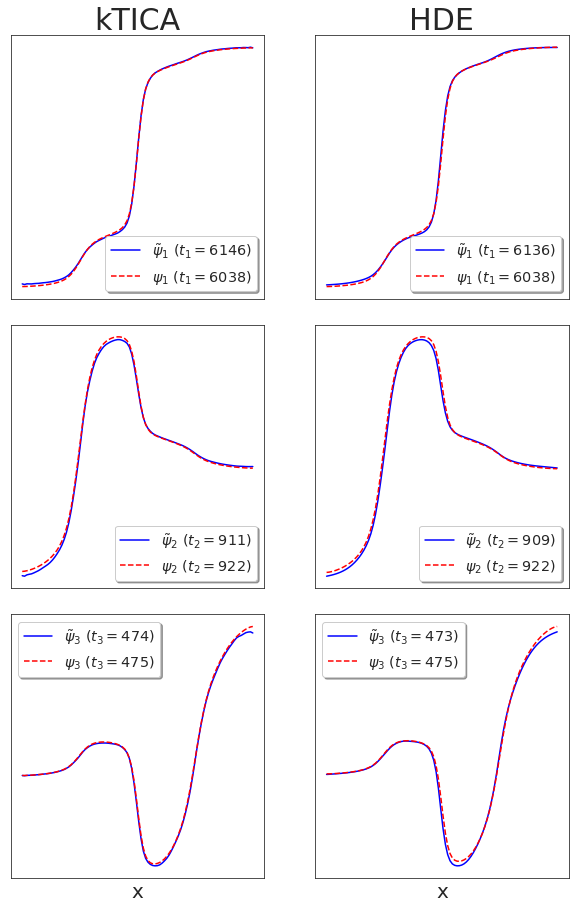

In [23]:
# plot learned eigenfunctions for KTICA and HDE
def plot_CV_state_with_coeff(CVs_state_list_list, row_label_list, timescale_list=None):
    num_list = len(CVs_state_list_list)
    num_states = len(CVs_state_list_list[0])
    fig, axes = plt.subplots(num_states, num_list)
    for index_list in range(num_list):
        CVs_state_list = CVs_state_list_list[index_list]
        for item in range(num_states):
            CVs_state_list[item] = normalize_state(CVs_state_list[item], equi_dist)
        for _1, item in enumerate(CVs_state_list):
            ax = axes[_1, index_list]
            ax.plot(x_list, item, label='$\\tilde{\psi}_%d\ (t_%d = %d)$' % (
                _1 + 1, _1 + 1, timescale_list[index_list][_1]), color='blue')
            ax.plot(x_list, eigenstates[_1 + 1], label='$\psi_%d\ (t_%d = %d)$' % (
                _1 + 1, _1 + 1, th_timescales[_1]), linestyle='dashed', color='red')
            legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
            coeff_list = get_decompose_coeff(item, eigenstates[:4], equi_dist)
            title_text = '$\\tilde{\psi}_%d = %s \psi_0 + %s \psi_1 + %s \psi_2 + %s \psi_3$' % (
                _1+1, coeff_list[0], coeff_list[1], coeff_list[2], coeff_list[3])
            if _1 == 0: ax.set_title(row_label_list[index_list], fontsize=30)
            if _1 > 1: ax.set_xlabel('x', fontsize = temp_font_size)
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
    plt.subplots_adjust(hspace=0.1)
    fig.set_size_inches(5 * num_list, num_states * 5 + 0.5)
    return fig

fig = plot_CV_state_with_coeff([ktica_proj.T, hde_proj.T], ['kTICA', 'HDE'], 
                               [ktica_timescales, hde_timescales])